In [ ]:
#Install libraries
!pip3 install transformers
!pip3 install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
# Importing libraries
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [ ]:
# Setting up GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
!git clone https://github.com/ChaymaeJhabli/FederatedLearning.git

Cloning into 'data'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), 604.11 KiB | 6.94 MiB/s, done.


In [ ]:
df = pd.read_csv('./FederatedLearning/data/dep1_sentiment_tweets3.csv')
df.head()

,Unnamed: 0,tweet,target
0,0,just had a real good moment. i missssssssss hi...,0
1,1,is reading manga http://plurk.com/p/mzp1e,0
2,2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,3,@lapcat Need to send 'em to my accountant tomo...,0
4,4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [ ]:
import pandas as pd

df = pd.DataFrame(df)
#Shuffling the DataFrame prevents the model from learning any patterns or biases based on the inherent order of the data
# Shuffle the DataFrame
df = df.sample(frac=1.0, replace=False)

# First 20 lines
print(df.head(20))

       Unnamed: 0                                              tweet  target
12609       12609  Are you experiencing hot flashes, irregular pe...       1
7411         7411                          Breakfast time me thinks        0
9726         9726  To come out of , you make friends but coming t...       0
10593       10593  The amount ae fucking spots I have right now h...       1
6026         6026     Overcast and gloomy, the opposite of my mood.        0
9545         9545  @VanBluesat @infrared_rock Among them, is Hawr...       0
6308         6308  Off the a birthday party for @ChrisQuick 's hu...       0
6227         6227  just gone done swimming wif my mom and my aunt...       0
2048         2048                  @Leo9018 good luck with that man        0
10701       10701                 In my feelings tonite .    # tired       1
7441         7441  @toddbennettjr @Elvis0725 @derrich @adam_goodm...       0
4706         4706  @OatsyWilliams wow ha that was entertaining?  ...       0

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

df['tweet'] = df['tweet'].apply(clean_text)


In [ ]:
#Initialization
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-04
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
#The class is defined to accept the Dataframe as input and generate tokenized output that is used by the DistilBERT model for training.
#The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        title = str(self.data.tweet[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8

# Split the full dataset into a train and test set
train_dataset1 = df.sample(frac=train_size, random_state=200)
test_dataset = df.drop(train_dataset1.index).reset_index(drop=True)
train_dataset1 = train_dataset1.reset_index(drop=True)

# Further split the training dataset into a training and validation set
train_dataset = train_dataset1.sample(frac=train_size, random_state=200)
val_dataset = train_dataset1.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

# Print the sizes of the datasets
print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATION  Dataset: {}".format(val_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# Create dataset objects using the Triage class
training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)
validating_set = Triage(val_dataset, tokenizer, MAX_LEN)


FULL Dataset: (13513, 3)
TRAIN Dataset: (8648, 3)
VALIDATION  Dataset: (2162, 3)
TEST Dataset: (2703, 3)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validating_loader = DataLoader(validating_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = DistillBERTClass()
model.to(device)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()

    # Variables to collect training metrics
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

    # Calculate training loss and accuracy for the epoch
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_accu)

    print(f'The Total Accuracy for Epoch {epoch}: {epoch_accu}')
    print(f"Training Loss Epoch: {epoch_loss}")
    print("-------------------------------")

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for _, data in enumerate(validating_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    val_loss /= len(validating_loader)
    val_acc = (val_correct / val_total) * 100
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
    print("-------------------------------")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy(train_acc, val_acc_list):
    plt.figure(figsize=(10, 5))
    x_axis = np.arange(1, len(train_acc) + 1)
    plt.plot(x_axis, train_acc, label='Train Accuracy', color='tab:orange')
    plt.plot(x_axis, val_acc_list, label='Validation Accuracy', color='tab:blue')
    plt.xlabel('Number of Rounds')
    plt.ylabel('Accuracy')
    plt.title("Training and Validation Accuracy vs. Global Rounds")
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

def plot_loss(train_loss, val_loss_list):
    plt.figure(figsize=(10, 5))
    x_axis = np.arange(1, len(train_loss) + 1)
    plt.plot(x_axis, train_loss, label='Train Loss', color='tab:red')
    plt.plot(x_axis, val_loss_list, label='Validation Loss', color='tab:green')
    plt.xlabel('Number of Rounds')
    plt.ylabel('Loss')
    plt.title("Training and Validation Loss vs. Global Rounds")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()


Training Loss per 5000 steps: 0.4348123073577881
Training Accuracy per 5000 steps: 87.5
The Total Accuracy for Epoch 0: 92.19472710453284
Training Loss Epoch: 0.2595602182252161
-------------------------------
Validation Loss: 0.2481052485458991, Validation Accuracy: 91.53561517113783
-------------------------------
Training Loss per 5000 steps: 0.28616365790367126
Training Accuracy per 5000 steps: 87.5
The Total Accuracy for Epoch 1: 93.05041628122109
Training Loss Epoch: 0.1968747078203957
-------------------------------
Validation Loss: 0.20931339176262126, Validation Accuracy: 92.46068455134136
-------------------------------
Training Loss per 5000 steps: 0.07797593623399734
Training Accuracy per 5000 steps: 96.875
The Total Accuracy for Epoch 2: 95.25901942645699
Training Loss Epoch: 0.1355200211562189
-------------------------------
Validation Loss: 0.25029009959989174, Validation Accuracy: 92.78445883441259
-------------------------------
Training Loss per 5000 steps: 0.06870617

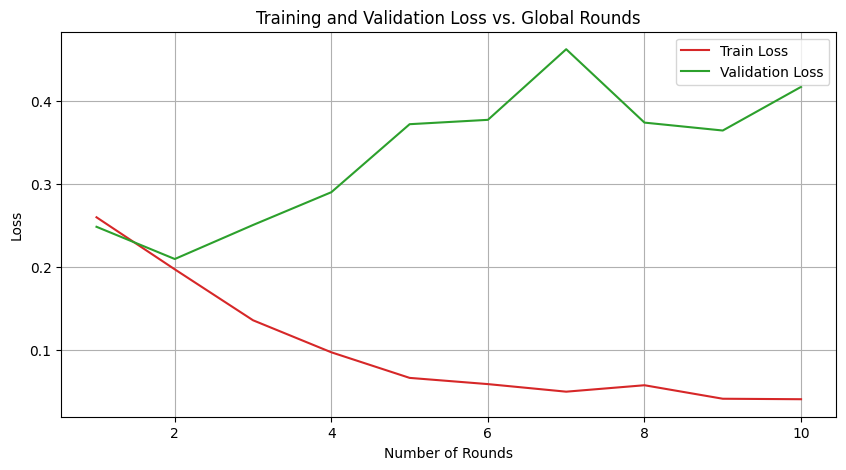

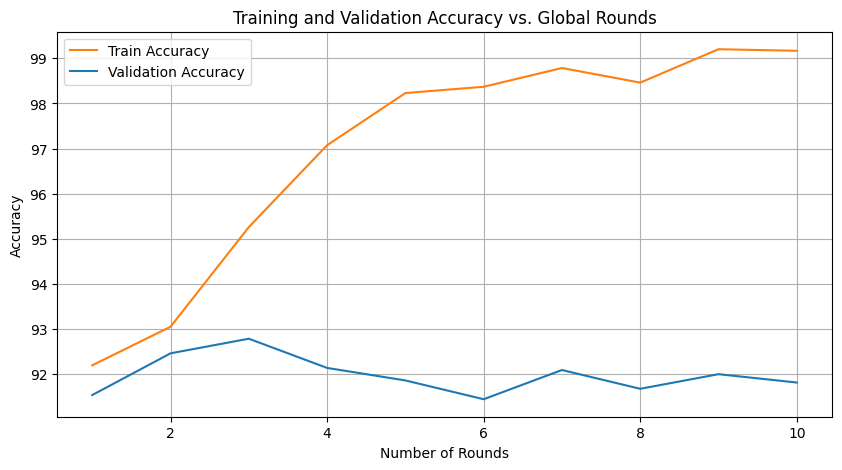

In [ ]:
# Training loop
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(epoch)
    train_loss_values.extend(train_loss)
    train_accuracy_values.extend(train_acc)
    val_loss_values.extend(val_loss)
    val_accuracy_values.extend(val_acc)

# Plotting the training and validation loss
plot_loss(train_loss_values, val_loss_values)

# Plotting the training and validation accuracy
plot_accuracy(train_accuracy_values, val_accuracy_values)



 **We notice that our model starts to overfit from 2 epochs**

In [ ]:
#Testing the trained model
def Test(model, testing_loader):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu


In [ ]:
print('This is the Test section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the Test dataset, the approcah is using more of pytorch')

acc = Test(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the Test section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the Test dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 0.3270626366138458
Validation Accuracy per 100 steps: 93.75
Validation Loss Epoch: 0.4105862486878818
Validation Accuracy Epoch: 92.67480577136514
Accuracy on test data = 92.67%
